# CNN Cancer Detection

## Project Summary
We are given thousands of images that we can use to detect cancerous cells in lymph nodes. The images are 96x96 pixels. The dataset is split into train and test sets, with train set containing 220,025 images and test set containing 56,500 images. The file train_labels.csv has two labels, an id for each filename and a label that indicates if the image is cancerous (1) or not (0). The goal is to predict the labels for the test images. 

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage import io
from collections import Counter
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, BatchNormalization

import warnings
warnings.simplefilter("ignore")

In [3]:
test = './histopathologic-cancer-detection/test/'
train = './histopathologic-cancer-detection/train/'
train_labels = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')

In [4]:
train_labels.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## EDA

The plan for analysis involves training CNNs to classify the images as either cancerous or not. Two models will be used: a simple baseline model and a complex model using techniques like batch normalization. The performance of each model will then be evaluated by accuracy and AUC-ROC. With the trained models we will then predict the labels for the test set.

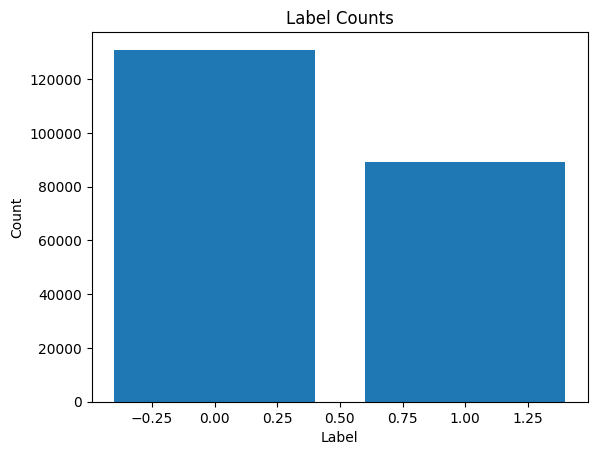

(130908, 89117)


In [5]:
label_counts = Counter(train_labels['label'])
labels, counts = zip(*label_counts.items())

plt.bar(labels, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.show()
print(counts)

In the subplot below we have a selection of images from the training set. Each image is labeled if it's cancerous or not, and there is a 32x32 box in the center of each image, as the cancerous cells are more likely to be centered in that area.

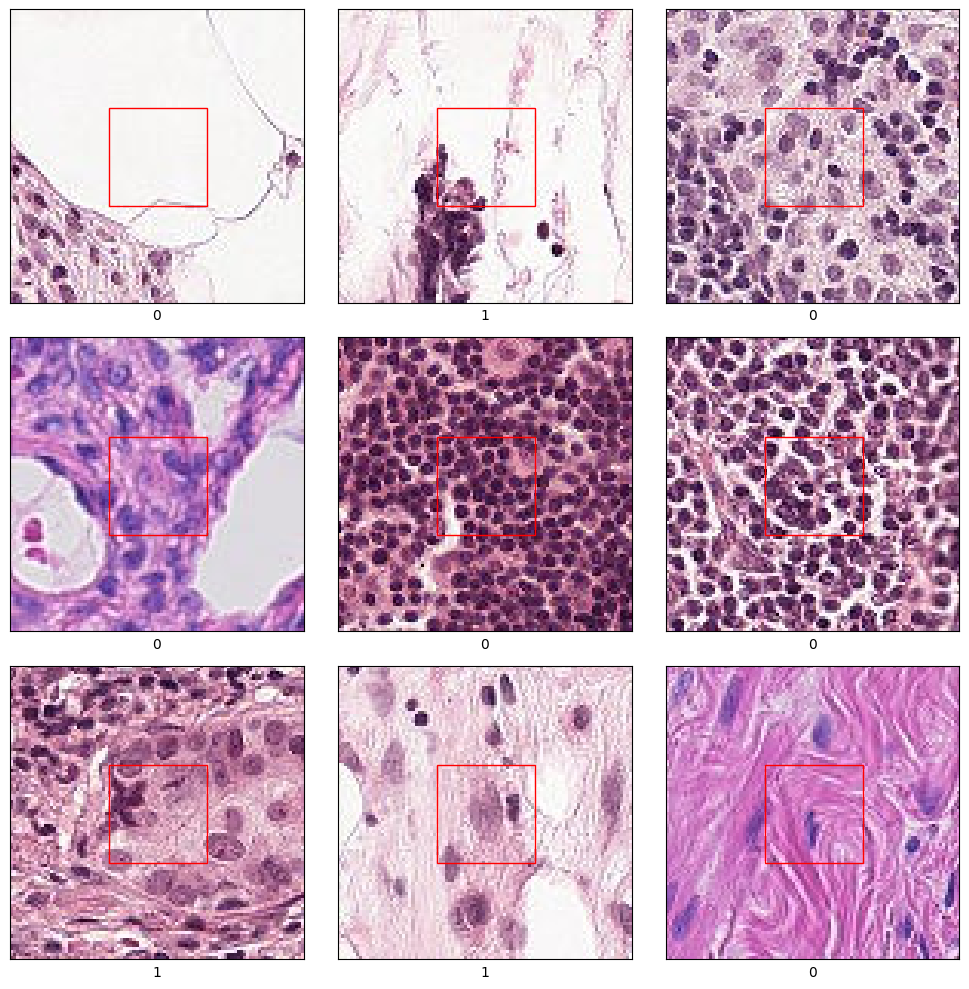

In [ ]:
fig, axes = plt.subplots(3, 3, figsize = (10, 10))

for ax, (image_id, label) in zip(axes.flat, zip(train_labels.id, train_labels.label)):
    file_path = f"{train}{image_id}.tif"
    image = io.imread(file_path)

    ax.imshow(image)

    # Add a red rectangle in center
    box = patches.Rectangle((32, 32), 32, 32, edgecolor = 'r', facecolor = 'none')
    ax.add_patch(box)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(label)

plt.tight_layout()
plt.show()

## Model Architecture

Two CNNs are used using two different architectures. 

Model 1:
* Convolutional and pooling layers

Model 2:
* Dropout and batch normalization

The Model 2 prevents overfitting to improve performance by using Hyperparameter tuning.

CNNs are great for this task due to their ability to learn hierarchical features. 

In [ ]:
train_labels['id'] = train_labels['id'].apply(lambda x: x + ".tif")
train_labels['label'] = train_labels['label'].astype(str)
train_labels = shuffle(train_labels, random_state = 49)

data = ImageDataGenerator(rescale = 1. / 255., validation_split = 0.15)

In [41]:
train_generator = data.flow_from_dataframe(
    dataframe = train_labels,
    directory = train,
    x_col = "id",
    y_col = "label",
    subset = "training",
    batch_size = 256,
    seed = 49,
    class_mode = "binary",
    target_size = (64, 64))

Found 187022 validated image filenames belonging to 2 classes.


In [42]:
valid_generator = data.flow_from_dataframe(
    dataframe = train_labels,
    directory = train,
    x_col = "id",
    y_col = "label",
    subset = "validation",
    batch_size = 256,
    seed = 49,
    class_mode = "binary",
    target_size = (64, 64))

Found 33003 validated image filenames belonging to 2 classes.


In [43]:
strategy = tf.distribute.get_strategy()

def create_model_one():
    with strategy.scope():
        model = Sequential()
        model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = (64, 64, 3)))
        model.add(Conv2D(filters = 16, kernel_size = (3, 3)))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Conv2D(filters = 32, kernel_size = (3, 3)))
        model.add(Conv2D(filters = 32, kernel_size = (3, 3)))
        model.add(AveragePooling2D(pool_size = (2, 2)))
        model.add(Flatten())
        model.add(Dense(1, activation = 'sigmoid'))
        model.compile(loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.AUC()])
        return model
    
def create_model_two():
    with strategy.scope():
        model = Sequential()
        model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (64, 64, 3)))
        model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))
        model.add(BatchNormalization())
        model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
        model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
        model.add(AveragePooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))
        model.add(BatchNormalization())
        model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
        model.add(Flatten())
        model.add(Dense(1, activation = 'sigmoid'))
        rmsprop_optimizer = RMSprop(learning_rate=0.0001)
        model.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()], optimizer=rmsprop_optimizer)
        return model

epoch = 3 since having a larger number will cause the script to take much longer to run

In [44]:
model_one = create_model_one()
history_model_one = model_one.fit(train_generator, epochs = 3, validation_data = valid_generator)

Epoch 1/3
731/731 [==============================] - 1568s 2s/step - loss: 0.5963 - accuracy: 0.6906 - auc_2: 0.7348 - val_loss: 0.5300 - val_accuracy: 0.7536 - val_auc_2: 0.8123
Epoch 2/3
731/731 [==============================] - 2209s 3s/step - loss: 0.5422 - accuracy: 0.7394 - auc_2: 0.7942 - val_loss: 0.5586 - val_accuracy: 0.7114 - val_auc_2: 0.8235
Epoch 3/3
731/731 [==============================] - 688s 941ms/step - loss: 0.5160 - accuracy: 0.7575 - auc_2: 0.8169 - val_loss: 0.5465 - val_accuracy: 0.7117 - val_auc_2: 0.8146


In [45]:
model_two = create_model_two()
history_model_two = model_two.fit(train_generator, epochs = 3, validation_data = valid_generator)

Epoch 1/3
731/731 [==============================] - 279s 380ms/step - loss: 0.4491 - accuracy: 0.7969 - auc_3: 0.8645 - val_loss: 0.5076 - val_accuracy: 0.7808 - val_auc_3: 0.8876
Epoch 2/3
731/731 [==============================] - 278s 380ms/step - loss: 0.3976 - accuracy: 0.8270 - auc_3: 0.8953 - val_loss: 0.4028 - val_accuracy: 0.8266 - val_auc_3: 0.9076
Epoch 3/3
731/731 [==============================] - 280s 383ms/step - loss: 0.3807 - accuracy: 0.8349 - auc_3: 0.9052 - val_loss: 0.5495 - val_accuracy: 0.7898 - val_auc_3: 0.8971


We can now plot both models and compare them to each other

{'loss': [0.5962592363357544, 0.542243480682373, 0.5160125494003296], 'accuracy': [0.6906299591064453, 0.7393889427185059, 0.7575098276138306], 'auc_2': [0.7348300218582153, 0.7941958904266357, 0.8169442415237427], 'val_loss': [0.5300107598304749, 0.5585560202598572, 0.5464615225791931], 'val_accuracy': [0.753598153591156, 0.7113898992538452, 0.7116625905036926], 'val_auc_2': [0.8123291730880737, 0.823523998260498, 0.8146385550498962]}


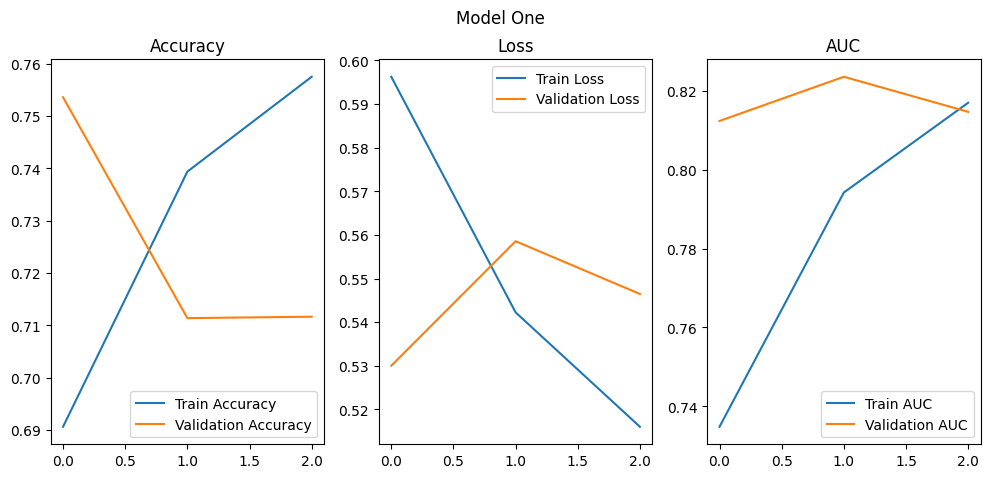

{'loss': [0.44913774728775024, 0.3975837826728821, 0.38072529435157776], 'accuracy': [0.7968848347663879, 0.8269936442375183, 0.8348857164382935], 'auc_3': [0.8644770383834839, 0.8953198790550232, 0.9051838517189026], 'val_loss': [0.5075809955596924, 0.4028226435184479, 0.5494677424430847], 'val_accuracy': [0.7808077931404114, 0.8265612125396729, 0.7897766828536987], 'val_auc_3': [0.8876386880874634, 0.90758216381073, 0.897064208984375]}


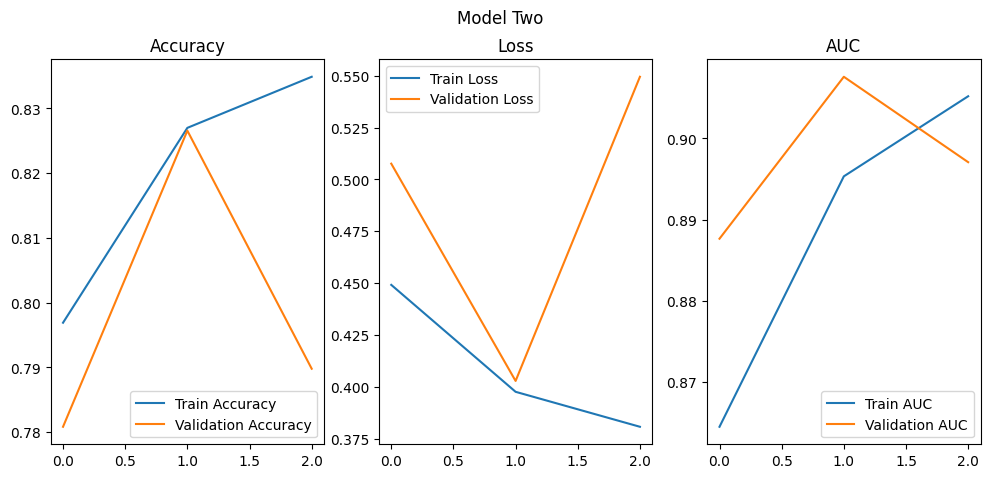

In [59]:
def plot_history(history, model_name):
    plt.figure(figsize = (12, 5))
    plt.suptitle(f"{model_name}")
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label = 'Train Accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label = 'Train Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.legend()
    plt.title("Loss")

    if model_name == "Model One":
        print(history.history)
        plt.subplot(1, 3, 3)
        plt.plot(history.history['auc_2'], label = 'Train AUC')
        plt.plot(history.history['val_auc_2'], label = 'Validation AUC')
        plt.legend()
        plt.title('AUC')
        plt.show()
    else:
        print(history.history)
        plt.subplot(1, 3, 3)
        plt.plot(history.history['auc_3'], label = 'Train AUC')
        plt.plot(history.history['val_auc_3'], label = 'Validation AUC')
        plt.legend()
        plt.title("AUC")
        plt.show()

plot_history(history_model_one, "Model One")
plot_history(history_model_two, "Model Two")

Now that the models have been trained, we can run the test set using model 2. 

In [68]:
test_df = pd.DataFrame({'id': os.listdir(test)})
data = ImageDataGenerator(rescale = 1./255.)

test_generator = data.flow_from_dataframe(
    dataframe = test_df,
    directory = test,
    x_col = 'id',
    y_col = None,
    target_size = (64, 64),
    batch_size = 1,
    shuffle = False,
    class_mode = None)

predictions = model_two.predict(test_generator, verbose = 1)
predictions = np.transpose(predictions)[0]

Found 57458 validated image filenames.
57458/57458 [==============================] - 140s 2ms/step


## Results



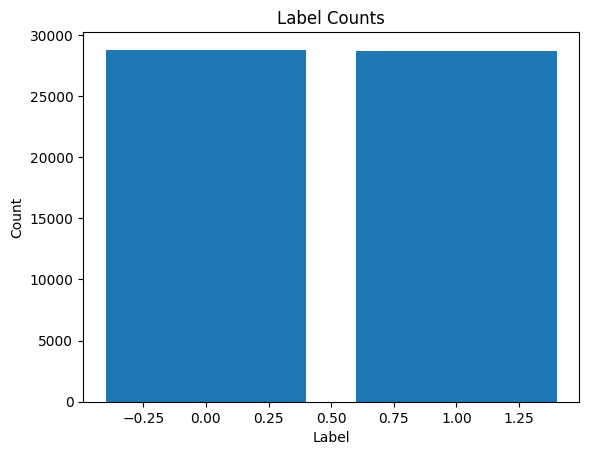

In [70]:
submission = pd.DataFrame()
submission['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

submission.to_csv('submission.csv', index = False)

submission['label'].value_counts()
label_counts = Counter(submission['label'])
labels, counts = zip(*label_counts.items())

plt.bar(labels, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.show()


## Analysis

We can see from the histogram and plots above how well both models performed. Model one shows steady improvement in training accuracy and AUC, while validation accuracy and AUC stagnat and decline a little after a while which suggests overfitting. Validation loss increase after the first epoch also indicates overfitting.
Model two shows more consistent learning patterns, with better training/validation accuracy and AUC, showing better generalization. The training and validation loss also decreases steadily, indicating its better performance over model one. In the histogram above we can see that model two labeled cancerous and non-cancerous images about equally. While the model has decent performance, too many false negatives makes it hard to use in real-world applications.

## Conclusion

The CNN models showed decent performance in classifying cancerous cells in the test set, with the more complex model two outperforming the simple model 1. Incorporating dropout and batch normalization to model 2 provided better results when testing with the test set. The performance could be improved, as the small number of epochs probably hindered the performance of each model. To improve performance, the epoch number could be increased, but this would require even more time, so parallel processing would be required in order to run the models in decent time. Other more sophisticed architectures could be used to further improve performance, as well as using more extensive hyperparameter tuning.